# Contents

1. [The Problem](#The-Problem)
2. [Common Libraries](#Common-Libraries)
3. [Import Data](#Import-Data)
4. [Explore Data](#Explore-Data)
5. [Prepare Data](#Prepare-Data)
6. [Shortlist Models](#Shortlist-Models)
7. [Tune Models](#Tune-Models)
8. [Submission](#Submission)

# The Problem

For now, you can read about the problem on Kaggle. 

Based on that, this qualifies as a supervised multivariate classification problem in which we'll use batch learning from the supplied dataset.

## Performance evaluation 
As described in the Kaggle description, the performance will be evaluated using the Macro F1 Score. 

Todo:
* Describe the F1 score and evaluate if it's a good fit.
* Is the right measure given the business objectives?
* Minimumm performance required?
* List assumptions

# Common Libraries

In [27]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Set up Seaborn with default theme, scaling, and color palette
sns.set()

# Import Data

In [6]:
def import_train_test():
    train = pd.read_csv('../input/train.csv')
    test = pd.read_csv('../input/test.csv')
    
    return train, test

train, test = import_train_test()

# Explore Data

In [10]:
print(train.shape)
train.head()

(9557, 143)


,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [11]:
print(test.shape)
test.head()

(23856, 142)


,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq
0,ID_2f6873615,NaN,0,5,0,1,1,0,NaN,1,...,4,0,16,9,0,1,2.25,0.25,272.25,16
1,ID_1c78846d2,NaN,0,5,0,1,1,0,NaN,1,...,41,256,1681,9,0,1,2.25,0.25,272.25,1681
2,ID_e5442cf6a,NaN,0,5,0,1,1,0,NaN,1,...,41,289,1681,9,0,1,2.25,0.25,272.25,1681
3,ID_a8db26a79,NaN,0,14,0,1,1,1,1.0,0,...,59,256,3481,1,256,0,1.00,0.00,256.00,3481
4,ID_a62966799,175000.0,0,4,0,1,1,1,1.0,0,...,18,121,324,1,0,1,0.25,64.00,NaN,324


Okay, first things we notice is that we have 9,557 rows in our training set and 23,856 in our test set. Each row represents an individual and the household they correspond it is indicated by their `idhogar` value. According to the business objective, we are only interested in classifying households, the `Target` should be the same for every individual in a household. Let's see how many households are in each set.

In [16]:
print(f"There are {len(train.idhogar.unique())} unique households in the training set.")
print(f"There are {len(test.idhogar.unique())} unique households in the test set.")

There are 2988 unique households in the training set.
There are 7352 unique households in the test set.


Almost 2.5 times the number of households in the test set. This means we should be very cautios to make sure that our model doesn't overfit the training set because if we do, we'll likely score pretty poorly on the test submission.

Let's take a look at the label distirbution both for individuals and household.

In [70]:
features_and_descriptions = [('v2a1', 'Monthly rent payment'),
                             ('hacdor', '=1 Overcrowding by bedrooms'),
                             ('rooms', 'number of all rooms in the house'),
                             ('hacapo', '=1 Overcrowding by rooms'),
                             ('v14a', '=1 has bathroom in the household'),
                             ('refrig', '=1 if the household has refrigerator'),
                             ('v18q', 'owns a tablet'),
                             ('v18q1', 'number of tablets household owns'),
                             ('r4h1', 'Males younger than 12 years of age'),
                             ('r4h2', 'Males 12 years of age and older'),
                             ('r4h3', 'Total males in the household'),
                             ('r4m1', 'Females younger than 12 years of age'),
                             ('r4m2', 'Females 12 years of age and older'),
                             ('r4m3', 'Total females in the household'),
                             ('r4t1', 'persons younger than 12 years of age'),
                             ('r4t2', 'persons 12 years of age and older'),
                             ('r4t3', 'Total persons in the household'),
                             ('tamhog', 'size of the household'),
                             ('tamviv', 'number of persons living in the household'),
                             ('escolari', 'years of schooling'),
                             ('rez_esc', 'Years behind in school'),
                             ('hhsize', 'household size'),
                             ('paredblolad', '=1 if predominant material on the outside wall is block or brick'),
                             ('paredzocalo', '"=1 if predominant material on the outside wall is socket (wood,  zinc or absbesto"'),
                             ('paredpreb', '=1 if predominant material on the outside wall is prefabricated or cement'),
                             ('pareddes', '=1 if predominant material on the outside wall is waste material'),
                             ('paredmad', '=1 if predominant material on the outside wall is wood'),
                             ('paredzinc', '=1 if predominant material on the outside wall is zink'),
                             ('paredfibras', '=1 if predominant material on the outside wall is natural fibers'),
                             ('paredother', '=1 if predominant material on the outside wall is other'),
                             ('pisomoscer', '"=1 if predominant material on the floor is mosaic,  ceramic,  terrazo"'),
                             ('pisocemento', '=1 if predominant material on the floor is cement'),
                             ('pisoother', '=1 if predominant material on the floor is other'),
                             ('pisonatur', '=1 if predominant material on the floor is  natural material'),
                             ('pisonotiene', '=1 if no floor at the household'),
                             ('pisomadera', '=1 if predominant material on the floor is wood'),
                             ('techozinc', '=1 if predominant material on the roof is metal foil or zink'),
                             ('techoentrepiso', '"=1 if predominant material on the roof is fiber cement,  mezzanine "'),
                             ('techocane', '=1 if predominant material on the roof is natural fibers'),
                             ('techootro', '=1 if predominant material on the roof is other'),
                             ('cielorazo', '=1 if the house has ceiling'),
                             ('abastaguadentro', '=1 if water provision inside the dwelling'),
                             ('abastaguafuera', '=1 if water provision outside the dwelling'),
                             ('abastaguano', '=1 if no water provision'),
                             ('public', '"=1 electricity from CNFL,  ICE,  ESPH/JASEC"'),
                             ('planpri', '=1 electricity from private plant'),
                             ('noelec', '=1 no electricity in the dwelling'),
                             ('coopele', '=1 electricity from cooperative'),
                             ('sanitario1', '=1 no toilet in the dwelling'),
                             ('sanitario2', '=1 toilet connected to sewer or cesspool'),
                             ('sanitario3', '=1 toilet connected to  septic tank'),
                             ('sanitario5', '=1 toilet connected to black hole or letrine'),
                             ('sanitario6', '=1 toilet connected to other system'),
                             ('energcocinar1', '=1 no main source of energy used for cooking (no kitchen)'),
                             ('energcocinar2', '=1 main source of energy used for cooking electricity'),
                             ('energcocinar3', '=1 main source of energy used for cooking gas'),
                             ('energcocinar4', '=1 main source of energy used for cooking wood charcoal'),
                             ('elimbasu1', '=1 if rubbish disposal mainly by tanker truck'),
                             ('elimbasu2', '=1 if rubbish disposal mainly by botan hollow or buried'),
                             ('elimbasu3', '=1 if rubbish disposal mainly by burning'),
                             ('elimbasu4', '=1 if rubbish disposal mainly by throwing in an unoccupied space'),
                             ('elimbasu5', '"=1 if rubbish disposal mainly by throwing in river,  creek or sea"'),
                             ('elimbasu6', '=1 if rubbish disposal mainly other'),
                             ('epared1', '=1 if walls are bad'),
                             ('epared2', '=1 if walls are regular'),
                             ('epared3', '=1 if walls are good'),
                             ('etecho1', '=1 if roof are bad'),
                             ('etecho2', '=1 if roof are regular'),
                             ('etecho3', '=1 if roof are good'),
                             ('eviv1', '=1 if floor are bad'),
                             ('eviv2', '=1 if floor are regular'),
                             ('eviv3', '=1 if floor are good'),
                             ('dis', '=1 if disable person'),
                             ('male', '=1 if male'),
                             ('female', '=1 if female'),
                             ('estadocivil1', '=1 if less than 10 years old'),
                             ('estadocivil2', '=1 if free or coupled uunion'),
                             ('estadocivil3', '=1 if married'),
                             ('estadocivil4', '=1 if divorced'),
                             ('estadocivil5', '=1 if separated'),
                             ('estadocivil6', '=1 if widow/er'),
                             ('estadocivil7', '=1 if single'),
                             ('parentesco1', '=1 if household head'),
                             ('parentesco2', '=1 if spouse/partner'),
                             ('parentesco3', '=1 if son/doughter'),
                             ('parentesco4', '=1 if stepson/doughter'),
                             ('parentesco5', '=1 if son/doughter in law'),
                             ('parentesco6', '=1 if grandson/doughter'),
                             ('parentesco7', '=1 if mother/father'),
                             ('parentesco8', '=1 if father/mother in law'),
                             ('parentesco9', '=1 if brother/sister'),
                             ('parentesco10', '=1 if brother/sister in law'),
                             ('parentesco11', '=1 if other family member'),
                             ('parentesco12', '=1 if other non family member'),
                             ('idhogar', 'Household level identifier'),
                             ('hogar_nin', 'Number of children 0 to 19 in household'),
                             ('hogar_adul', 'Number of adults in household'),
                             ('hogar_mayor', '# of individuals 65+ in the household'),
                             ('hogar_total', '# of total individuals in the household'),
                             ('dependency', 'Dependency rate, calculated = (number of members of the household younger than 19 or older than 64)/(number of member of household between 19 and 64)'),
                             ('edjefe', 'years of education of male head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0'),
                             ('edjefa', 'years of education of female head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0'),
                             ('meaneduc', 'average years of education for adults (18+)'),
                             ('instlevel1', '=1 no level of education'),
                             ('instlevel2', '=1 incomplete primary'),
                             ('instlevel3', '=1 complete primary'),
                             ('instlevel4', '=1 incomplete academic secondary level'),
                             ('instlevel5', '=1 complete academic secondary level'),
                             ('instlevel6', '=1 incomplete technical secondary level'),
                             ('instlevel7', '=1 complete technical secondary level'),
                             ('instlevel8', '=1 undergraduate and higher education'),
                             ('instlevel9', '=1 postgraduate higher education'),
                             ('bedrooms', 'number of bedrooms'),
                             ('overcrowding', '# persons per room'),
                             ('tipovivi1', '=1 own and fully paid house'),
                             ('tipovivi2', '"=1 own,  paying in installments"'),
                             ('tipovivi3', '=1 rented'),
                             ('tipovivi4', '=1 precarious'),
                             ('tipovivi5', '"=1 other(assigned,  borrowed)"'),
                             ('computer', '=1 if the household has notebook or desktop computer'),
                             ('television', '=1 if the household has TV'),
                             ('mobilephone', '=1 if mobile phone'),
                             ('qmobilephone', '# of mobile phones'),
                             ('lugar1', '=1 region Central'),
                             ('lugar2', '=1 region Chorotega'),
                             ('lugar3', '=1 region PacÃƒÂ­fico central'),
                             ('lugar4', '=1 region Brunca'),
                             ('lugar5', '=1 region Huetar AtlÃƒÂ¡ntica'),
                             ('lugar6', '=1 region Huetar Norte'),
                             ('area1', '=1 zona urbana'),
                             ('area2', '=2 zona rural'),
                             ('age', 'Age in years'),
                             ('SQBescolari', 'escolari squared'),
                             ('SQBage', 'age squared'),
                             ('SQBhogar_total', 'hogar_total squared'),
                             ('SQBedjefe', 'edjefe squared'),
                             ('SQBhogar_nin', 'hogar_nin squared'),
                             ('SQBovercrowding', 'overcrowding squared'),
                             ('SQBdependency', 'dependency squared'),
                             ('SQBmeaned', 'square of the mean years of education of adults (>=18) in the household'),
                             ('agesq', 'Age squared')]

household_features_and_descriptions = [('v2a1', 'Monthly rent payment'),
                             ('hacdor', '=1 Overcrowding by bedrooms'),
                             ('rooms', 'number of all rooms in the house'),
                             ('hacapo', '=1 Overcrowding by rooms'),
                             ('v14a', '=1 has bathroom in the household'),
                             ('refrig', '=1 if the household has refrigerator'),
                             ('v18q1', 'number of tablets household owns'),
                             ('r4h1', 'Males younger than 12 years of age'),
                             ('r4h2', 'Males 12 years of age and older'),
                             ('r4h3', 'Total males in the household'),
                             ('r4m1', 'Females younger than 12 years of age'),
                             ('r4m2', 'Females 12 years of age and older'),
                             ('r4m3', 'Total females in the household'),
                             ('r4t1', 'persons younger than 12 years of age'),
                             ('r4t2', 'persons 12 years of age and older'),
                             ('r4t3', 'Total persons in the household'),
                             ('tamhog', 'size of the household'),
                             ('tamviv', 'number of persons living in the household'),
                             ('hhsize', 'household size'),
                             ('paredblolad', '=1 if predominant material on the outside wall is block or brick'),
                             ('paredzocalo', '"=1 if predominant material on the outside wall is socket (wood,  zinc or absbesto"'),
                             ('paredpreb', '=1 if predominant material on the outside wall is prefabricated or cement'),
                             ('pareddes', '=1 if predominant material on the outside wall is waste material'),
                             ('paredmad', '=1 if predominant material on the outside wall is wood'),
                             ('paredzinc', '=1 if predominant material on the outside wall is zink'),
                             ('paredfibras', '=1 if predominant material on the outside wall is natural fibers'),
                             ('paredother', '=1 if predominant material on the outside wall is other'),
                             ('pisomoscer', '"=1 if predominant material on the floor is mosaic,  ceramic,  terrazo"'),
                             ('pisocemento', '=1 if predominant material on the floor is cement'),
                             ('pisoother', '=1 if predominant material on the floor is other'),
                             ('pisonatur', '=1 if predominant material on the floor is  natural material'),
                             ('pisonotiene', '=1 if no floor at the household'),
                             ('pisomadera', '=1 if predominant material on the floor is wood'),
                             ('techozinc', '=1 if predominant material on the roof is metal foil or zink'),
                             ('techoentrepiso', '"=1 if predominant material on the roof is fiber cement,  mezzanine "'),
                             ('techocane', '=1 if predominant material on the roof is natural fibers'),
                             ('techootro', '=1 if predominant material on the roof is other'),
                             ('cielorazo', '=1 if the house has ceiling'),
                             ('abastaguadentro', '=1 if water provision inside the dwelling'),
                             ('abastaguafuera', '=1 if water provision outside the dwelling'),
                             ('abastaguano', '=1 if no water provision'),
                             ('public', '"=1 electricity from CNFL,  ICE,  ESPH/JASEC"'),
                             ('planpri', '=1 electricity from private plant'),
                             ('noelec', '=1 no electricity in the dwelling'),
                             ('coopele', '=1 electricity from cooperative'),
                             ('sanitario1', '=1 no toilet in the dwelling'),
                             ('sanitario2', '=1 toilet connected to sewer or cesspool'),
                             ('sanitario3', '=1 toilet connected to  septic tank'),
                             ('sanitario5', '=1 toilet connected to black hole or letrine'),
                             ('sanitario6', '=1 toilet connected to other system'),
                             ('energcocinar1', '=1 no main source of energy used for cooking (no kitchen)'),
                             ('energcocinar2', '=1 main source of energy used for cooking electricity'),
                             ('energcocinar3', '=1 main source of energy used for cooking gas'),
                             ('energcocinar4', '=1 main source of energy used for cooking wood charcoal'),
                             ('elimbasu1', '=1 if rubbish disposal mainly by tanker truck'),
                             ('elimbasu2', '=1 if rubbish disposal mainly by botan hollow or buried'),
                             ('elimbasu3', '=1 if rubbish disposal mainly by burning'),
                             ('elimbasu4', '=1 if rubbish disposal mainly by throwing in an unoccupied space'),
                             ('elimbasu5', '"=1 if rubbish disposal mainly by throwing in river,  creek or sea"'),
                             ('elimbasu6', '=1 if rubbish disposal mainly other'),
                             ('epared1', '=1 if walls are bad'),
                             ('epared2', '=1 if walls are regular'),
                             ('epared3', '=1 if walls are good'),
                             ('etecho1', '=1 if roof are bad'),
                             ('etecho2', '=1 if roof are regular'),
                             ('etecho3', '=1 if roof are good'),
                             ('eviv1', '=1 if floor are bad'),
                             ('eviv2', '=1 if floor are regular'),
                             ('eviv3', '=1 if floor are good'),
                             ('hogar_nin', 'Number of children 0 to 19 in household'),
                             ('hogar_adul', 'Number of adults in household'),
                             ('hogar_mayor', '# of individuals 65+ in the household'),
                             ('hogar_total', '# of total individuals in the household'),
                             ('dependency', 'Dependency rate, calculated = (number of members of the household younger than 19 or older than 64)/(number of member of household between 19 and 64)'),
                             ('edjefe', 'years of education of male head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0'),
                             ('edjefa', 'years of education of female head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0'),
                             ('meaneduc', 'average years of education for adults (18+)'),
                             ('bedrooms', 'number of bedrooms'),
                             ('overcrowding', '# persons per room'),
                             ('tipovivi1', '=1 own and fully paid house'),
                             ('tipovivi2', '"=1 own,  paying in installments"'),
                             ('tipovivi3', '=1 rented'),
                             ('tipovivi4', '=1 precarious'),
                             ('tipovivi5', '"=1 other(assigned,  borrowed)"'),
                             ('computer', '=1 if the household has notebook or desktop computer'),
                             ('television', '=1 if the household has TV'),
                             ('mobilephone', '=1 if mobile phone'),
                             ('qmobilephone', '# of mobile phones'),
                             ('lugar1', '=1 region Central'),
                             ('lugar2', '=1 region Chorotega'),
                             ('lugar3', '=1 region PacÃƒÂ­fico central'),
                             ('lugar4', '=1 region Brunca'),
                             ('lugar5', '=1 region Huetar AtlÃƒÂ¡ntica'),
                             ('lugar6', '=1 region Huetar Norte'),
                             ('area1', '=1 zona urbana'),
                             ('area2', '=2 zona rural')]

household_features = [feature for feature, description in household_features_and_descriptions]

individual_features_and_descriptions = [('v18q', 'owns a tablet'),
                             ('escolari', 'years of schooling'),
                             ('rez_esc', 'Years behind in school'),
                             ('dis', '=1 if disable person'),
                             ('male', '=1 if male'),
                             ('female', '=1 if female'),
                             ('estadocivil1', '=1 if less than 10 years old'),
                             ('estadocivil2', '=1 if free or coupled uunion'),
                             ('estadocivil3', '=1 if married'),
                             ('estadocivil4', '=1 if divorced'),
                             ('estadocivil5', '=1 if separated'),
                             ('estadocivil6', '=1 if widow/er'),
                             ('estadocivil7', '=1 if single'),
                             ('parentesco1', '=1 if household head'),
                             ('parentesco2', '=1 if spouse/partner'),
                             ('parentesco3', '=1 if son/doughter'),
                             ('parentesco4', '=1 if stepson/doughter'),
                             ('parentesco5', '=1 if son/doughter in law'),
                             ('parentesco6', '=1 if grandson/doughter'),
                             ('parentesco7', '=1 if mother/father'),
                             ('parentesco8', '=1 if father/mother in law'),
                             ('parentesco9', '=1 if brother/sister'),
                             ('parentesco10', '=1 if brother/sister in law'),
                             ('parentesco11', '=1 if other family member'),
                             ('parentesco12', '=1 if other non family member'),
                             ('instlevel1', '=1 no level of education'),
                             ('instlevel2', '=1 incomplete primary'),
                             ('instlevel3', '=1 complete primary'),
                             ('instlevel4', '=1 incomplete academic secondary level'),
                             ('instlevel5', '=1 complete academic secondary level'),
                             ('instlevel6', '=1 incomplete technical secondary level'),
                             ('instlevel7', '=1 complete technical secondary level'),
                             ('instlevel8', '=1 undergraduate and higher education'),
                             ('instlevel9', '=1 postgraduate higher education'),
                             ('age', 'Age in years')]

individual_features = [feature for feature, description in individual_features_and_descriptions]

In [74]:
household_groups = train.groupby('idhogar')

# Verify that all the rows in a household group have the same value for the household features
assert len(household_groups) == len(train.idhogar.unique()), "Length of household groups is not the same as the number of unique household ids."
assert not household_groups[["idhogar"] + household_features].var().any().any(), "Not all rows for a group have the same values for a household feature"

In [83]:
def extract_households(data):
    """Returns dataframe for households only using
    attributes that apply to the household"""
    
    households = data.groupby('idhogar')[['idhogar', 'Target'] + household_features].first()
    
    return households
    
    
train_households = extract_households(train)
assert len(train_households) == len(train.idhogar.unique()), f"Extracted households length ({len(train_households)}) doesn't match unique household indentifiers in train set ({len(train.idhogar.unique())})."

train_households.head()

,idhogar,Target,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q1,r4h1,...,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2
idhogar,,,,,,,,,,,,,,,,,,,,,
001ff74ca,001ff74ca,4,NaN,0,6,0,1,1,1.0,0,...,1,1,0,0,0,1,0,0,0,1
003123ec2,003123ec2,2,NaN,0,3,0,1,1,NaN,2,...,1,2,0,0,0,0,1,0,1,0
004616164,004616164,2,NaN,0,4,0,1,1,NaN,0,...,1,2,0,1,0,0,0,0,0,1
004983866,004983866,3,NaN,0,5,0,1,1,NaN,0,...,1,2,0,0,1,0,0,0,1,0
005905417,005905417,2,NaN,0,8,0,1,0,NaN,1,...,1,1,0,0,0,1,0,0,0,1


Text(0.5,1,'Train Households')

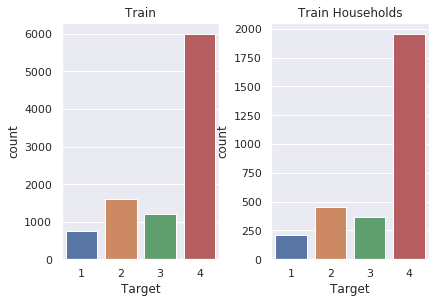

In [97]:
fig, axs = plt.subplots(1,2)
fig.tight_layout()

sns.countplot(x='Target', data=train, ax=axs[0])
axs[0].set_title("Train")

sns.countplot(x='Target', data=train_households, ax=axs[1])
axs[1].set_title("Train Households")

Okay, looks like we're okay in terms of the distributions between the train set and the extracted households. We should take not that our classes are very imbalanced. If the test set follows the same distribution, we could use a naive model that simply predicts the `Target` to be 4 and we'll be right over 65% of the time. This certainly won't help IDB figure out how to focus their support, since most households would be classified as non-vulnerable and, therefore, not in need of additional support. Still, it's good to be aware of this as we evaluate our models.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe8763576d8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fe876316dd8>]], dtype=object)

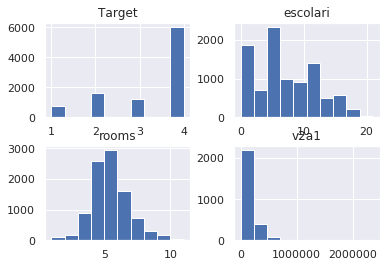

In [32]:
train.hist(["Target", "v2a1", "rooms", "escolari"])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe87d09eb38>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fe87c3bc4a8>]], dtype=object)

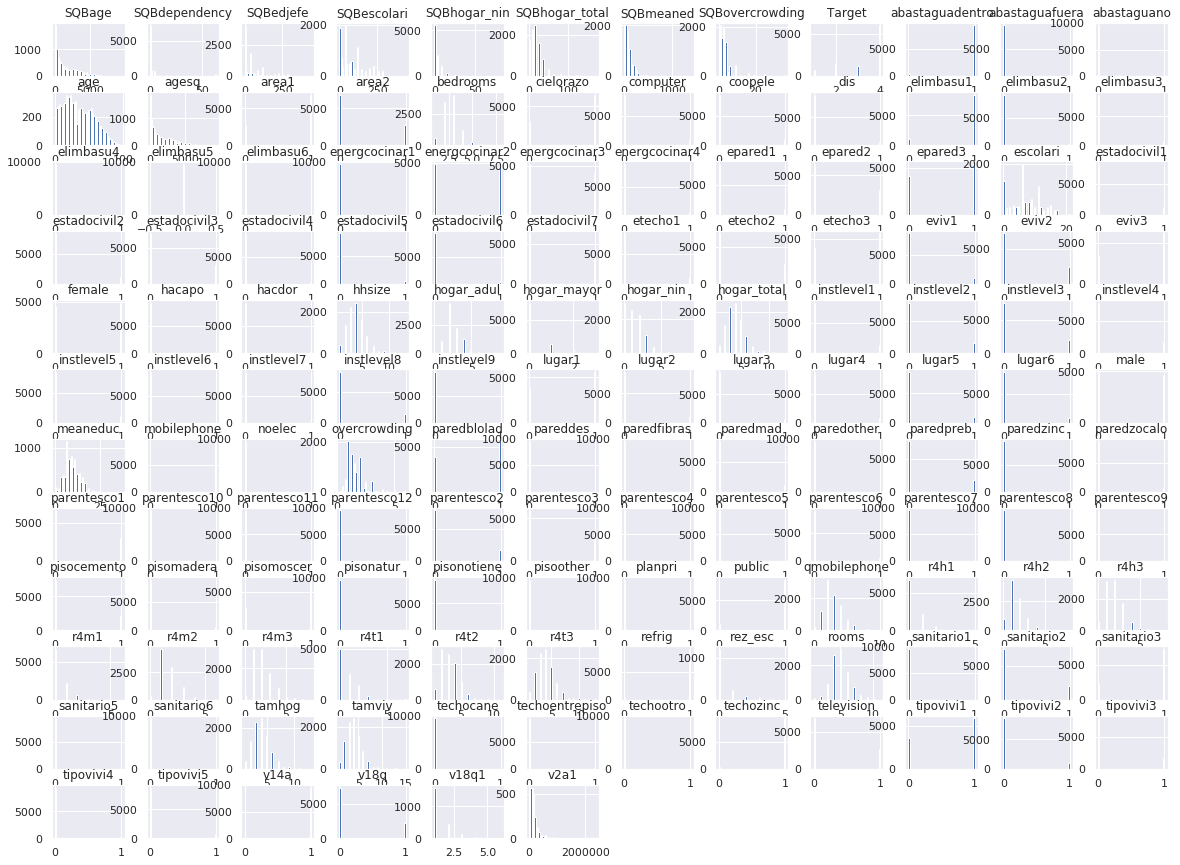

In [21]:
train.hist(bins=50, figsize=(20,15))

# Prepare Data

# Shortlist Models

# Tune Models

# Submit